In [5]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
CROP_LEFT = 94
CROP_TOP = 41
CROP_RIGHT = 13

# Указать пути до папок
input_dataset_path = "/kaggle/input/split-comb-b-yzva"
cropped_dataset_path = "/kaggle/working/cropped-dataset"

# Кусок по обрезке изображений
dataset_splits = ["train", "test", "val"]
for split in dataset_splits:
    split_input_path = os.path.join(input_dataset_path, split)
    split_cropped_path = os.path.join(cropped_dataset_path, split)
    os.makedirs(split_cropped_path, exist_ok=True)
    
    for class_name in os.listdir(split_input_path):
        class_input_path = os.path.join(split_input_path, class_name)
        class_cropped_path = os.path.join(split_cropped_path, class_name)
        os.makedirs(class_cropped_path, exist_ok=True)
        
        if os.path.isdir(class_input_path):
            for image_name in os.listdir(class_input_path):
                img_path = os.path.join(class_input_path, image_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                h, w, _ = img.shape
                # Обрезаем по вышеуказанным константам 3/4 краёв изображений
                cropped_img = img[CROP_TOP:, CROP_LEFT:w - CROP_RIGHT]
                output_path = os.path.join(class_cropped_path, image_name)
                cv2.imwrite(output_path, cropped_img)

print("Обрезка изображений завершена. Сохранено в:", cropped_dataset_path)

Обрезка изображений завершена. Сохранено в: /kaggle/working/cropped-dataset


Распределение изображений по подвыборкам

In [7]:
import pandas as pd

base_dir = "/kaggle/working/cropped-dataset"
splits   = ["train", "val", "test"]

records = []
for split in splits:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        print(f"Сплит не найден: {split_dir}")
        continue

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Count PNG files (case‐insensitive)
        png_files = [f for f in os.listdir(class_dir)
                     if f.lower().endswith(".png")]

        records.append({
            "подвыборка":       split,
            "класс":       class_name,
            "число изображений":   len(png_files)
        })

df = pd.DataFrame(records)

for split, group in df.groupby("подвыборка"):
    print(f"== {split.upper():10s} ==")
    for _, row in group.iterrows():
        print(f"{row['класс']:<20s} : {row['число изображений']}")

display(df.sort_values(["подвыборка","класс"]).reset_index(drop=True))

== TEST       ==
noise_ice_cracking   : 3
brak                 : 3
noise_clean          : 5
noise_lake           : 10
== TRAIN      ==
noise_ice_cracking   : 9
brak                 : 10
noise_clean          : 19
noise_lake           : 41
== VAL        ==
noise_ice_cracking   : 2
brak                 : 2
noise_clean          : 4
noise_lake           : 8


,подвыборка,класс,число изображений
0,test,brak,3
1,test,noise_clean,5
2,test,noise_ice_cracking,3
3,test,noise_lake,10
4,train,brak,10
5,train,noise_clean,19
6,train,noise_ice_cracking,9
7,train,noise_lake,41
8,val,brak,2
9,val,noise_clean,4


# Обучение модели

In [8]:
# --- Импорт библиотек ---
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # HuggingFace/DeiT и другие трансформер-модели
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import optuna  # Оптимизация гиперпараметров
from optuna.trial import TrialState
import joblib  # Для сериализации объектов (например, Optuna study)

# --- Фиксация зерна случайности для воспроизводимости ---
torch.manual_seed(42)
np.random.seed(42)

# --- Гиперпараметры для обучения VPT (Visual Prompt Tuning) на модели DeiT-Small/16 ---
num_epochs = 20                # Общее количество эпох
batch_size = 16                # Размер батча
learning_rate = 1e-4           # Начальная скорость обучения
weight_decay = 0.05            # L2-регуляризация (снижение переобучения)
warmup_epochs = int(0.05 * num_epochs)  # Эпохи "разогрева"
dropout_rate = 0.25            # Вероятность dropout
label_smoothing = 0.1          # Сглаживание меток (для стабильности обучения)
prompt_dim = 768               # Размерность скрытого пространства DeiT-Small (для токенов-промптов)
prompt_tokens = 10             # Количество добавляемых промптов
early_stopping_patience = 8    # Останов при отсутствии улучшения

# --- Пути к папкам с данными ---
data_dir = "/kaggle/working/cropped-dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# --- Преобразования изображений для каждого этапа ---
# Все изображения приводятся к размеру 224x224 (соответствует входу DeiT)
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(224),         # Масштабирование до 224x224
        transforms.CenterCrop(224),     # Центрированная обрезка
        transforms.ToTensor(),          # Преобразование в тензор
        transforms.Normalize(           # Нормализация под ImageNet
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),         # Более крупный размер для валидации
        transforms.CenterCrop(224),     # Обрезка до 224x224
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
}

In [10]:
# --- Загрузка датасетов из директорий ---
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms["train"])
val_dataset   = datasets.ImageFolder(root=val_dir, transform=data_transforms["val"])
test_dataset  = datasets.ImageFolder(root=test_dir, transform=data_transforms["test"])

print("Оригинальные классы:", train_dataset.classes)

# --- Создание отображения меток (в данном случае — прямое, без изменений) ---
# Оригинальные классы: ['brak_Empty zone', 'brak_Station', 'noise_DNS', 'noise_Tip-off']
# Целевые классы те же
class_mapping = {}
for i, cls in enumerate(train_dataset.classes):
    class_mapping[i] = i  # Прямое отображение (0→0, 1→1 и т.д.)

# --- Обёртка над датасетом для переопределения меток согласно отображению ---
class MappedDataset(torch.utils.data.Dataset):
    """Оборачивает существующий датасет и заменяет метки в соответствии с заданным отображением."""
    def __init__(self, dataset, mapping):
        self.dataset = dataset
        self.mapping = mapping
        self.classes = [dataset.classes[mapping[i]] for i in range(len(dataset.classes))]

    def __getitem__(self, index):
        img, label = self.dataset[index]
        return img, self.mapping[label]  # Возвращается переотображенная метка

    def __len__(self):
        return len(self.dataset)

# --- Применение отображения ко всем частям датасета ---
train_dataset_mapped = MappedDataset(train_dataset, class_mapping)
val_dataset_mapped   = MappedDataset(val_dataset, class_mapping)
test_dataset_mapped  = MappedDataset(test_dataset, class_mapping)

# --- MixUp и CutMix отключены ---
mixup_fn = None

# --- Загрузчики данных ---
train_loader = DataLoader(train_dataset_mapped, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset_mapped,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset_mapped,  batch_size=batch_size, shuffle=False, num_workers=2)

# --- Устройство для вычислений ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# --- Подсчёт количества образцов в тренировочном датасете по классам ---
counts = {
    'brak':  10,
    'noise_clean':     19,
    'noise_ice_cracking':       9,
    'noise_lake':    41,
}

# --- Общая статистика ---
N = sum(counts.values())  # Общее количество образцов: 378
K = len(counts)           # Количество классов: 4

# --- Вычисление весов классов: w_i = N / (K * n_i) ---
weights = []
for cls in train_dataset.classes:
    n_i = counts[cls]
    w_i = N / (K * n_i)
    weights.append(w_i)

# --- Преобразование весов в тензор и перенос на нужное устройство ---
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Порядок классов:", train_dataset.classes)
print("Веса классов:", class_weights)

weight_dict = {
    'brak': 0.5,
    'noise_clean': 2.0,
    'noise_ice_cracking': 0.5,
    'noise_lake': 3.0
}


Оригинальные классы: ['brak', 'noise_clean', 'noise_ice_cracking', 'noise_lake']
Используемое устройство: cuda
Порядок классов: ['brak', 'noise_clean', 'noise_ice_cracking', 'noise_lake']
Веса классов: tensor([1.9750, 1.0395, 2.1944, 0.4817], device='cuda:0')


In [15]:
class VPTDeiTSmallShallow(nn.Module):
    """
    Модель: DeiT-Small/16 + VPT-Shallow (prompt-токены только на входе).
    Обучаются: prompt-токены, их позиционные эмбеддинги и классификационная голова.
    """
    def __init__(self, num_classes=4, prompt_len=10, dropout=0.0):
        super().__init__()

        self.backbone = timm.create_model('deit_small_patch16_224', pretrained=True)
        embed_dim = self.backbone.embed_dim  # 384

        # --- Заморозка всех весов ---
        for p in self.backbone.parameters():
            p.requires_grad = False

        # --- Инициализация prompt-токенов и их позиционных эмбеддингов ---
        self.prompt = nn.Parameter(torch.randn(1, prompt_len, embed_dim) * 0.02)
        self.prompt_pos = nn.Parameter(torch.zeros(1, prompt_len, embed_dim))
        nn.init.trunc_normal_(self.prompt_pos, std=0.02)

        # --- Заменяем классификационную голову ---
        self.backbone.reset_classifier(num_classes)
        for p in self.backbone.head.parameters():
            p.requires_grad = True

        self.dropout = nn.Dropout(dropout)

    def _add_positional_embed(self, x):
        """Добавление CLS + Prompt + Patch позиционных эмбеддингов"""
        B = x.size(0)
        cls_pos = self.backbone.pos_embed[:, :1, :]
        patch_pos = self.backbone.pos_embed[:, 1:, :]
        pos = torch.cat([cls_pos, self.prompt_pos, patch_pos], dim=1)
        return x + pos.expand(B, -1, -1)

    def forward(self, imgs):  # imgs: [B, 3, 224, 224]
        B = imgs.size(0)
        x = self.backbone.patch_embed(imgs)
        cls_tok = self.backbone.cls_token.expand(B, -1, -1)
        prompt_tok = self.prompt.expand(B, -1, -1)
        x = torch.cat((cls_tok, prompt_tok, x), dim=1)
        x = self._add_positional_embed(x)
        x = self.backbone.pos_drop(x)

        for blk in self.backbone.blocks:
            x = blk(x)

        x = self.backbone.norm(x)
        x = self.dropout(x[:, 0])
        return self.backbone.head(x)


# Функция потерь Focal Loss — применяется при несбалансированных классах
class FocalLoss(nn.Module):
    def __init__(self, gamma: float = 2.0, weight: torch.Tensor = None, reduction: str = "mean"):
        super().__init__()
        self.gamma = gamma                 # параметр фокусировки
        self.weight = weight              # веса классов
        self.reduction = reduction        # способ агрегации результата

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        logp = nn.functional.log_softmax(logits, dim=1)         # логарифм вероятностей по логитам
        p    = torch.exp(logp)                                  # преобразование логарифма к вероятностям

        logp_t = logp.gather(1, targets.unsqueeze(1)).squeeze(1)  # логарифм вероятности для правильного класса
        p_t    = p.gather(1, targets.unsqueeze(1)).squeeze(1)     # вероятность для правильного класса

        loss = - (1 - p_t) ** self.gamma * logp_t               # формула Focal Loss

        if self.weight is not None:
            loss = loss * self.weight[targets]                  # применение весов классов

        if self.reduction == "mean":
            return loss.mean()                                  # усреднение по батчу
        elif self.reduction == "sum":
            return loss.sum()                                   # суммирование
        return loss                                             # без агрегации


# Планировщик скорости обучения с косинусным спадом и разогревом
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=0.0):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))  # линейный рост в фазе разогрева
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))    # косинусное затухание после разогрева

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [16]:
import warnings
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

# Подавление некритичных предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def objective(trial):
    # 1) Простой набор гиперпараметров
    lr         = trial.suggest_loguniform("lr", 1e-5, 5e-4)
    wd         = trial.suggest_loguniform("wd", 1e-6, 1e-2)
    bs         = trial.suggest_categorical("batch_size", [4, 8, 16])
    prompt_len = trial.suggest_int("prompt_len", 5, 15)
    dropout    = trial.suggest_uniform("dropout", 0.0, 0.5)
    gamma      = trial.suggest_uniform("focal_gamma", 0.0, 3.0)

    # жёстко фиксируем количество эпох под маленькую выборку
    num_epochs = trial.suggest_int("num_epochs", 3, 6)

    # 2) Даталоадеры
    train_loader = DataLoader(train_dataset_mapped, batch_size=bs, shuffle=True,  num_workers=2)
    val_loader   = DataLoader(val_dataset_mapped,   batch_size=bs, shuffle=False, num_workers=2)

    # 3) Модель — только shallow
    model = VPTDeiTSmallShallow(len(train_dataset.classes), prompt_len, dropout=dropout).to(device)
    # Замораживаем весь бэкбон (только prompt + head учатся)
    for p in model.backbone.parameters():
        p.requires_grad = False

    # 4) Loss, optimizer, scheduler с фиксированным warmup
    criterion = FocalLoss(gamma=gamma, weight=class_weights, reduction="mean")
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

    steps        = len(train_loader)
    total_steps  = num_epochs * steps
    warmup_steps = int(0.1 * total_steps)  # fixed warmup_ratio=0.1
    scheduler    = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # 5) Тренировочный цикл
    best_val_f1, no_improve = 0.0, 0
    patience = 3

    for epoch in range(1, num_epochs + 1):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss   = criterion(logits, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Валидируем
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_preds   += logits.argmax(dim=1).cpu().tolist()
                val_targets += y.cpu().tolist()

        val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # ранняя остановка
        if val_f1 > best_val_f1:
            best_val_f1, no_improve = val_f1, 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    return best_val_f1


# Запуск
study = optuna.create_study(direction="maximize", study_name="vpt_shallow_small")
study.optimize(objective, n_trials=20)


# Сохранение результата оптимизации
joblib.dump(study, "vpt_deit_optuna_study.pkl")

# Вывод параметров лучшей итерации
print("Лучшая итерация:")
trial = study.best_trial
print(f"  Значение (F1-макро): {trial.value:.4f}")
print("  Подобранные параметры:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-04 01:55:50,649] A new study created in memory with name: vpt_shallow_small


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

[I 2025-05-04 01:56:18,118] Trial 0 finished with value: 0.22619047619047616 and parameters: {'lr': 0.00015192843321443355, 'wd': 4.0037879626746255e-05, 'batch_size': 4, 'prompt_len': 12, 'dropout': 0.2572627931772712, 'focal_gamma': 1.6006500914924968, 'num_epochs': 5}. Best is trial 0 with value: 0.22619047619047616.
[I 2025-05-04 01:56:34,048] Trial 1 finished with value: 0.041666666666666664 and parameters: {'lr': 1.4638911194369928e-05, 'wd': 0.00021119841470538283, 'batch_size': 8, 'prompt_len': 14, 'dropout': 0.26436718837354894, 'focal_gamma': 2.906163421189024, 'num_epochs': 3}. Best is trial 0 with value: 0.22619047619047616.
[I 2025-05-04 01:56:54,436] Trial 2 finished with value: 0.38888888888888884 and parameters: {'lr': 1.3698651449892897e-05, 'wd': 2.0342256257337462e-05, 'batch_size': 8, 'prompt_len': 7, 'dropout': 0.005597607065897625, 'focal_gamma': 1.843808771171504, 'num_epochs': 4}. Best is trial 2 with value: 0.38888888888888884.
[I 2025-05-04 01:57:25,450] Trial

Лучшая итерация:
  Значение (F1-макро): 0.4167
  Подобранные параметры:
    lr: 0.00017882435088369843
    wd: 6.382774829801004e-06
    batch_size: 4
    prompt_len: 8
    dropout: 0.16663185766470645
    focal_gamma: 2.262788637279325
    num_epochs: 3


Best trial:
  Value (F1-macro): 0.8793
  Params:
    lr: 0.00020104790055885596
    wd: 0.05105674531308548
    batch_size: 8
    prompt_len: 7
    dropout: 0.36644852540353456
    warmup_ratio: 0.13880939466522085
    focal_gamma: 4.04797919352297
    unfreeze_blocks: 1
    vpt_mode: shallow
    num_epochs: 5
Creating VPT-Shallow on DeiT-Small/16 model with prompt length 7...
Unfreezing the last 1 transformer blocks
Total parameters: 21,672,580
Trainable parameters: 1,781,380 (8.22%)
Best parameters saved to 'vpt_deit_best_params.pth'

In [18]:
# Загрузка лучших гиперпараметров для финального обучения модели
best_params = study.best_trial.params

# Установка параметров финального обучения
num_epochs = 8                           # полный run
batch_size = best_params["batch_size"]
learning_rate = best_params["lr"]
weight_decay = best_params["wd"]
prompt_tokens = best_params["prompt_len"]
early_stopping_patience = 100
warmup_ratio = 0.1                       # фиксированный warmup-ratio
gamma = best_params["focal_gamma"]

# Подготовка загрузчиков данных с оптимальным размером батча
train_loader = DataLoader(train_dataset_mapped, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset_mapped,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset_mapped,  batch_size=batch_size, shuffle=False, num_workers=2)

# Инициализация только shallow-модели VPT
model = VPTDeiTSmallShallow(
    num_classes=len(train_dataset.classes),
    prompt_len=prompt_tokens
).to(device)
print(f"Создана VPT-Shallow/DeiT-Small с длиной промпта {prompt_tokens}")

# Замораживаем весь backbone (только prompt-токены и голова обучаются)
for p in model.backbone.parameters():
    p.requires_grad = False

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}, обучаемых: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

# Инициализация функции потерь, оптимизатора и планировщика
criterion = FocalLoss(gamma=gamma, weight=class_weights, reduction="mean")
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

steps_per_epoch = len(train_loader)
total_steps  = num_epochs * steps_per_epoch
warmup_steps = int(warmup_ratio * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Сборка конфигурации для сохранения
config = {
    'backbone':       'deit_small_patch16_224',
    'prompt_len':     prompt_tokens,
    'num_epochs':     num_epochs,
    'batch_size':     batch_size,
    'learning_rate':  learning_rate,
    'weight_decay':   weight_decay,
    'warmup_ratio':   warmup_ratio,
    'focal_gamma':    gamma
}

# Сохранение параметров и конфига
torch.save({
    'best_params': best_params,
    'config':      config
}, 'vpt_deit_best_params.pth')
print("Лучшие параметры сохранены в 'vpt_deit_best_params.pth'")

Создана VPT-Shallow/DeiT-Small с длиной промпта 8
Всего параметров: 21,673,348, обучаемых: 6,144 (0.0%)
Лучшие параметры сохранены в 'vpt_deit_best_params.pth'



Начало обучения на 8 эпох(и)...


Эпоха 1 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 1/8  Потери на обучении: 0.7892  Потери на валидации: 0.8215  F1-макро на валидации: 0.2389
  → Новое лучшее значение F1-макро на эпохе 1: 0.2389 (чекпоинт сохранён)


Эпоха 2 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 2 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 2/8  Потери на обучении: 0.7307  Потери на валидации: 0.7904  F1-макро на валидации: 0.2538
  → Новое лучшее значение F1-макро на эпохе 2: 0.2538 (чекпоинт сохранён)


Эпоха 3 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 3 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 3/8  Потери на обучении: 0.6872  Потери на валидации: 0.7649  F1-макро на валидации: 0.2333
  → Нет улучшения на протяжении 1 эпох(и)


Эпоха 4 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 4 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 4/8  Потери на обучении: 0.6443  Потери на валидации: 0.7628  F1-макро на валидации: 0.2639
  → Новое лучшее значение F1-макро на эпохе 4: 0.2639 (чекпоинт сохранён)


Эпоха 5 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 5 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 5/8  Потери на обучении: 0.6158  Потери на валидации: 0.7309  F1-макро на валидации: 0.3083
  → Новое лучшее значение F1-макро на эпохе 5: 0.3083 (чекпоинт сохранён)


Эпоха 6 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 6 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 6/8  Потери на обучении: 0.5924  Потери на валидации: 0.7252  F1-макро на валидации: 0.3083
  → Нет улучшения на протяжении 1 эпох(и)


Эпоха 7 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 7 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 7/8  Потери на обучении: 0.5796  Потери на валидации: 0.7258  F1-макро на валидации: 0.3083
  → Нет улучшения на протяжении 2 эпох(и)


Эпоха 8 — обучение:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 8 — валидация:   0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 8/8  Потери на обучении: 0.5731  Потери на валидации: 0.7245  F1-макро на валидации: 0.3083
  → Нет улучшения на протяжении 3 эпох(и)

Обучение завершено за 0.64 минут
Лучшая эпоха: 5, лучший F1-макро: 0.3083


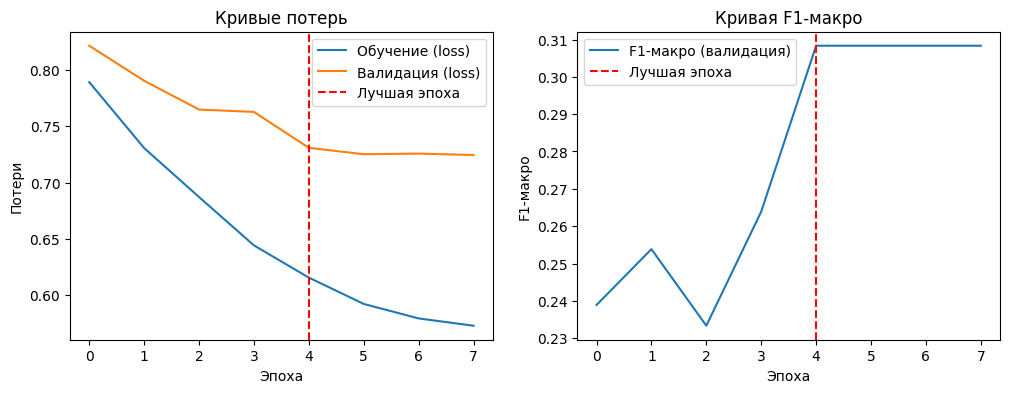

In [19]:
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# --- Основной цикл обучения с отслеживанием F1-макро и досрочной остановкой ---
best_val_f1 = 0.0        # Лучшее значение F1-макро на валидации
best_epoch = 0           # Номер эпохи с лучшим результатом
no_improve = 0           # Счётчик эпох без улучшения

train_losses, val_losses, val_f1s = [], [], []  # Журналы значений

print(f"\nНачало обучения на {num_epochs} эпох(и)...")
t0 = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()  # Режим обучения
    run_loss, total, correct = 0.0, 0, 0

    for x, y in tqdm(train_loader, desc=f"Эпоха {epoch} — обучение"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        run_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)

    train_loss = run_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # --- Валидация ---
    model.eval()  # Режим оценки
    run_loss, all_preds, all_targets = 0.0, [], []

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Эпоха {epoch} — валидация"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            run_loss += loss.item() * x.size(0)

            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(y.cpu().tolist())

    val_loss = run_loss / len(val_loader.dataset)
    val_f1 = f1_score(all_targets, all_preds, average='macro')

    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Эпоха {epoch}/{num_epochs}  "
          f"Потери на обучении: {train_loss:.4f}  "
          f"Потери на валидации: {val_loss:.4f}  "
          f"F1-макро на валидации: {val_f1:.4f}")

    # --- Проверка на улучшение и сохранение чекпоинта ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'config': config,
            'val_f1_macro': best_val_f1
        }, 'vpt_deit_best_f1.pth')
        print(f"  → Новое лучшее значение F1-макро на эпохе {epoch}: {best_val_f1:.4f} (чекпоинт сохранён)")
    else:
        no_improve += 1
        print(f"  → Нет улучшения на протяжении {no_improve} эпох(и)")
        if no_improve >= early_stopping_patience:
            print(f"Досрочная остановка на эпохе {epoch}")
            break

total_time = time.time() - t0
print(f"\nОбучение завершено за {total_time/60:.2f} минут")
print(f"Лучшая эпоха: {best_epoch}, лучший F1-макро: {best_val_f1:.4f}")

# --- Построение графиков обучения ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучение (loss)')
plt.plot(val_losses, label='Валидация (loss)')
plt.axvline(best_epoch - 1, color='r', linestyle='--', label='Лучшая эпоха')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Кривые потерь')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='F1-макро (валидация)')
plt.axvline(best_epoch - 1, color='r', linestyle='--', label='Лучшая эпоха')
plt.xlabel('Эпоха')
plt.ylabel('F1-макро')
plt.title('Кривая F1-макро')
plt.legend()

plt.show()


Загрузка лучшего чекпоинта для финальной оценки...
Загружена эпоха 5 с F1-макро на валидации: 0.3083

Финальная валидация — Потери: 0.7309, F1-макро: 0.3083


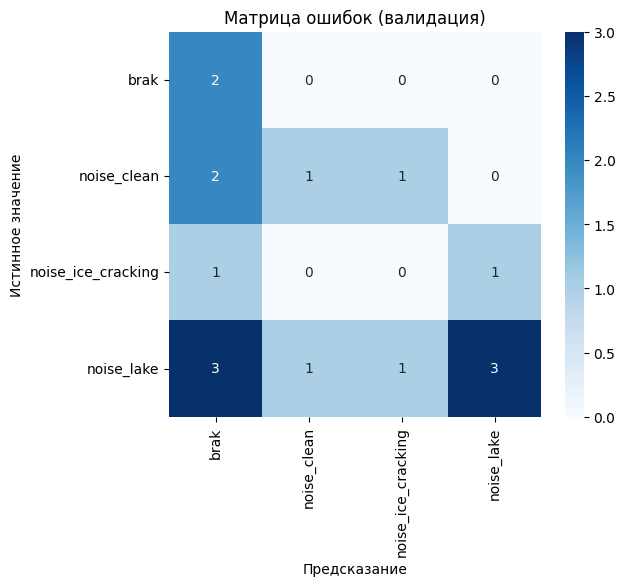


Тестовая выборка — Потери: 0.7988, F1-макро: 0.2740


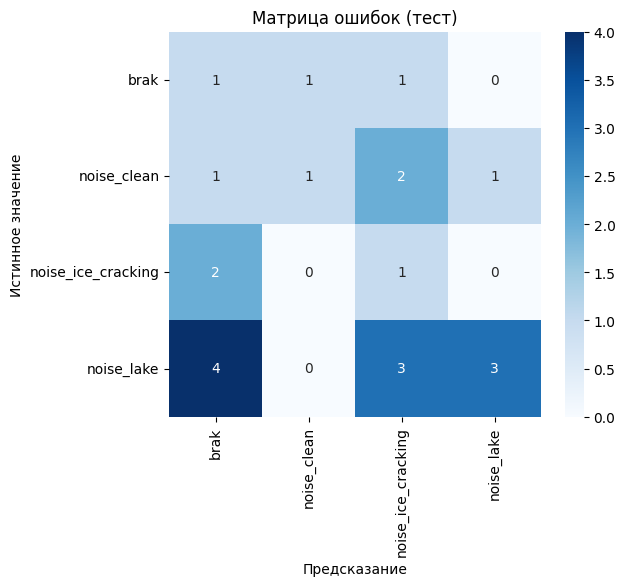

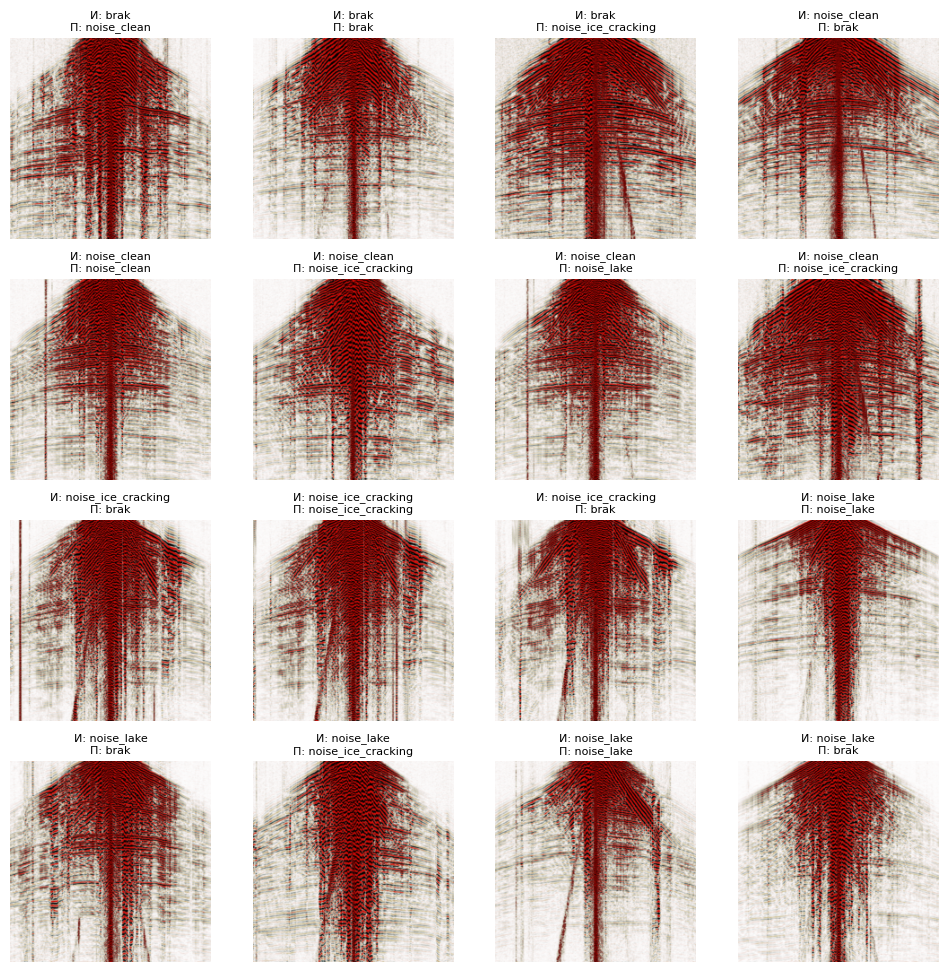


Подробный отчёт по метрикам (тестовая выборка):
                    precision    recall  f1-score   support

              brak     0.1250    0.3333    0.1818         3
       noise_clean     0.5000    0.2000    0.2857         5
noise_ice_cracking     0.1429    0.3333    0.2000         3
        noise_lake     0.7500    0.3000    0.4286        10

          accuracy                         0.2857        21
         macro avg     0.3795    0.2917    0.2740        21
      weighted avg     0.5145    0.2857    0.3267        21


Финальная модель и конфигурация сохранены в файл 'vpt_deit_final.pth'


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- Загрузка лучшего чекпоинта и оценка на валидации ---
print("\nЗагрузка лучшего чекпоинта для финальной оценки...")
ckpt = torch.load('vpt_deit_best_f1.pth')
model.load_state_dict(ckpt['model_state_dict'])
print(f"Загружена эпоха {ckpt['epoch']} с F1-макро на валидации: {ckpt['val_f1_macro']:.4f}")

# --- Валидация модели на сохранённом состоянии ---
model.eval()
val_running_loss = 0.0
val_all_preds, val_all_targets = [], []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        val_all_preds.extend(preds.cpu().tolist())
        val_all_targets.extend(targets.cpu().tolist())

val_loss = val_running_loss / len(val_loader.dataset)
val_f1   = f1_score(val_all_targets, val_all_preds, average='macro')
print(f"\nФинальная валидация — Потери: {val_loss:.4f}, F1-макро: {val_f1:.4f}")

# Построение матрицы ошибок для валидации
cm_val = confusion_matrix(val_all_targets, val_all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Матрица ошибок (валидация)')
plt.xlabel('Предсказание')
plt.ylabel('Истинное значение')
plt.show()

# --- Оценка модели на тестовой выборке ---
model.eval()
test_running_loss = 0.0
test_all_preds, test_all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        test_all_preds.extend(preds.cpu().tolist())
        test_all_targets.extend(targets.cpu().tolist())

test_loss = test_running_loss / len(test_loader.dataset)
test_f1   = f1_score(test_all_targets, test_all_preds, average='macro')
print(f"\nТестовая выборка — Потери: {test_loss:.4f}, F1-макро: {test_f1:.4f}")

# Построение матрицы ошибок для теста
cm_test = confusion_matrix(test_all_targets, test_all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Матрица ошибок (тест)')
plt.xlabel('Предсказание')
plt.ylabel('Истинное значение')
plt.show()

# --- Визуализация нескольких предсказаний на тестовой выборке ---
model.eval()
examples, ex_labels, ex_preds = [], [], []
with torch.no_grad():
    for imgs_batch, labels_batch in test_loader:
        imgs_batch = imgs_batch.to(device)
        outputs = model(imgs_batch)
        _, ps = outputs.max(1)
        for img, lbl, pr in zip(imgs_batch, labels_batch, ps):
            examples.append(img.cpu())
            ex_labels.append(lbl.item())
            ex_preds.append(pr.item())
            if len(examples) >= 16:
                break
        if len(examples) >= 16:
            break

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    im = examples[i].permute(1, 2, 0).numpy()
    im = (im * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # обратная нормализация
    ax.imshow(np.clip(im, 0, 1))
    ax.axis('off')
    ax.set_title(f"И: {train_dataset.classes[ex_labels[i]]}\nП: {train_dataset.classes[ex_preds[i]]}", fontsize=8)
plt.show()

# --- Подробный отчёт по метрикам на тестовой выборке ---
print("\nПодробный отчёт по метрикам (тестовая выборка):")
print(classification_report(
    test_all_targets,
    test_all_preds,
    target_names=train_dataset.classes,
    digits=4
))

# --- Сохранение финального состояния модели и её конфигурации ---
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config
}, 'vpt_deit_final.pth')
print("\nФинальная модель и конфигурация сохранены в файл 'vpt_deit_final.pth'")